In [10]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm
import pathlib


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS #######################
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import engine
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable, Sequence, List, Tuple, Dict, Optional, Union, Any
from types import ModuleType
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from generators import BlenderStandardDataset, TorchStandardDataset
import importlib
from pprint import pprint
import sqlite3 as db

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Unexpected GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)


def reloader(module_or_member: Union[ModuleType, Any]):    
    if isinstance(module_or_member, ModuleType):
        importlib.reload(module_or_member)
        return module
    else:
        module = importlib.import_module(module_or_member.__module__)
        importlib.reload(module)
        return module.__dict__[module_or_member.__name__]

In [12]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [13]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
SQL_TABLE = 'bboxes_std'
WEIGHTS_DIR = 'fish_statedicts'
NUM_CLASSES=6+1

In [14]:
db_con = db.connect(f'file:{os.path.join(DATASET_DIR,"bboxes.db")}?mode=ro', uri=True)

In [15]:
n_data = pd.read_sql_query('SELECT COUNT(DISTINCT(imgnr)) FROM bboxes_std', db_con).values[0][0]

TRAIN_RANGE = (0, int(3/4*n_data))
VAL_RANGE = (int(3/4*n_data), n_data)

In [16]:
torch.hub.set_dir(TORCH_CACHE_DIR)

In [17]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load(
            os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), 
            model='detr_resnet50', 
            pretrained=False,
            source='local'
        )
        
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

model = DETRModel(NUM_CLASSES, 100)
model = model.to(device)

In [28]:
def save_model(obj: Any, f: str):
    pathlib.Path(f).parent.mkdir(parents=True, exist_ok=True)
    assert isinstance(f, str), "Filename must be of type string when saving model"
    torch.save(obj=obj, f=f)
    
    
class FishTrainer:
    def __init__(self,         
        trainloader: DataLoader, 
        model: nn.Module, 
        criterion, 
        optimizer, 
        n_epochs: int = 1, 
        device: Optional[torch.device] = None, 
        valloader: DataLoader = None, 
        save_best: bool = True,
        verbosity: int=1
    ):
        self.verbosity = verbosity
        self.train_loss = np.inf
        self.val_loss = np.inf
        self.best_val_loss = np.inf
    
    def train(self): ...
        
        
    
    def test(self): ...
        

def train_model(
        trainloader: DataLoader, 
        valloader: DataLoader, 
        model: nn.Module, 
        criterion, 
        optimizer, 
        n_epochs: int, 
        device: torch.device, 
        save_best: bool = True
    ):
    
    best_val_loss = np.inf
    
    for epoch in range(n_epochs):

        running_train_loss = 0.0

        trainbar = tqdm(
            iterable=enumerate(trainloader, 0),
            total=len(trainloader),
            unit=' batches',
            desc=f' Epoch {epoch+1}/{n_epochs}',
            ascii=True,
            position=0,
            leave=False
        )

        model.train()
        criterion.train()
        
        # Loop through train batches
        for i, (images, labels) in trainbar:
            images = [image.to(device) for image in images]
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
            print(labels)

            output = model(images)
            loss_dict = criterion(output, labels)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
            # Zero parameter gradients since PyTorch will just accumulate the gradient
            # vectors while it trains (in order to get the "mean" direction to move in
            # the parameter space). Also doing it this way minimizes memory allocation
            # etc, probably.
            optimizer.zero_grad()
    
            losses.backward() # Computes gradients
            optimizer.step() # Do a gradient step
    
            # print statistics
            running_train_loss += losses.item()
            train_loss = running_train_loss / (i+1)
            traintqdminfo = {'train loss':train_loss}
            trainbar.set_postfix(traintqdminfo)
         
        running_val_loss = 0.0
        
        # valbar will disappear after it is done since leave=False
        valbar = tqdm(
            iterable=enumerate(valloader, 0), 
            total=len(valloader), 
            unit=' batches',
            desc=f' Validating',
            ascii=True,
            position=0,
            leave=False
        )
        
        model.eval()
        criterion.eval()
        
        # Loop through val batches
        with torch.no_grad():
            for i, (images, labels) in valbar:
                images = [image.to(device) for image in images]
                labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

                output = model(images)

                loss_dict = criterion(output, labels)
                weight_dict = criterion.weight_dict
                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                # print statistics
                running_val_loss += losses.item()
                val_loss = running_val_loss / (i+1)
                valtqdminfo = {**traintqdminfo, 'val loss':val_loss}
                valbar.set_postfix(valtqdminfo)
        
        # Extra dirty tqdm hack hehe
        trainbar.disable = False
        trainbar.set_postfix({**traintqdminfo, **valtqdminfo})
        trainbar.disable = True
        print(file=sys.stderr)
        
        # Save best models
        if save_best:
            if valtqdminfo['val loss'] < best_val_loss:
                isodatenow = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
                daydir = datetime.today().strftime("weights_%Y-%m-%d")
                filename = (
                    f'detr_statedicts_epoch{epoch+1}'
                    f'_train{train_loss:.4f}_val{val_loss:.4f}'
                    f'_{isodatenow}.pth'
                )
                filepath = os.path.join(WEIGHTS_DIR, daydir, filename)

                save_model(
                    obj={
                        'model':model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'criterion':criterion.state_dict(),
                    },
                    f = filepath
                )
        
            

In [29]:
weight_dict = {'loss_ce': 10, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher()
criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = 0.5, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-7)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=8e-5, momentum=0.001, dampening=0.000001)

BATCH_SIZE = 8
traingen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(0,32))
valgen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False, imgnrs=range(32,48))

In [30]:
trainloader = DataLoader(
    dataset=traingen,
    batch_size=8,
    collate_fn=lambda x: tuple(zip(*x)),
)

valloader = DataLoader(
    dataset=valgen,
    batch_size=8,
    collate_fn=lambda x: tuple(zip(*x)),
)

train_model(
    trainloader,
    valloader,
    model,
    criterion,
    optimizer,
    n_epochs=20000,
    device=device,
    save_best=False
)

 Epoch 1/20000:   0%|          | 0/4 [00:00<?, ? batches/s]

[{'labels': tensor([2, 4, 0, 5], device='cuda:1'), 'boxes': tensor([[0.7770, 0.4730, 0.1240, 0.2450],
        [0.1190, 0.5320, 0.2330, 0.0770],
        [0.4940, 0.5220, 0.2360, 0.3760],
        [0.1730, 0.5280, 0.1520, 0.0640]], device='cuda:1')}, {'labels': tensor([2, 0, 1, 1, 3], device='cuda:1'), 'boxes': tensor([[0.4930, 0.4400, 0.0380, 0.2520],
        [0.6180, 0.2520, 0.1660, 0.4510],
        [0.6120, 0.3560, 0.0960, 0.3750],
        [0.2180, 0.1960, 0.1230, 0.2920],
        [0.5320, 0.4820, 0.3760, 0.4560]], device='cuda:1')}, {'labels': tensor([0, 3, 5], device='cuda:1'), 'boxes': tensor([[0.6860, 0.5760, 0.1130, 0.2210],
        [0.2120, 0.0690, 0.0940, 0.3510],
        [0.3930, 0.2700, 0.2300, 0.1420]], device='cuda:1')}, {'labels': tensor([5, 5, 2], device='cuda:1'), 'boxes': tensor([[0.5360, 0.1700, 0.2090, 0.1550],
        [0.1810, 0.7190, 0.0660, 0.2810],
        [0.1770, 0.2090, 0.1790, 0.3350]], device='cuda:1')}, {'labels': tensor([5], device='cuda:1'), 'boxes': tensor

 Epoch 1/20000:  50%|#####     | 2/4 [00:00<00:00,  3.73 batches/s, train loss=4.94]

[{'labels': tensor([5, 1, 2, 2, 4], device='cuda:1'), 'boxes': tensor([[0.6990, 0.4580, 0.1000, 0.2180],
        [0.2080, 0.0000, 0.2020, 0.2360],
        [0.0050, 0.2800, 0.4020, 0.3860],
        [0.1380, 0.5900, 0.1140, 0.2740],
        [0.1560, 0.4580, 0.1860, 0.0580]], device='cuda:1')}, {'labels': tensor([1, 4, 1, 3], device='cuda:1'), 'boxes': tensor([[0.7490, 0.0000, 0.2230, 0.3460],
        [0.2530, 0.7530, 0.1400, 0.0840],
        [0.0950, 0.2370, 0.2840, 0.1370],
        [0.4810, 0.3160, 0.2200, 0.3930]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.3150, 0.6080, 0.0860, 0.2550]], device='cuda:1')}, {'labels': tensor([0], device='cuda:1'), 'boxes': tensor([[0.6080, 0.4090, 0.1170, 0.3610]], device='cuda:1')}, {'labels': tensor([0, 2], device='cuda:1'), 'boxes': tensor([[0.2580, 0.6320, 0.2150, 0.1130],
        [0.5670, 0.4810, 0.1180, 0.2280]], device='cuda:1')}, {'labels': tensor([2, 4, 3, 2], device='cuda:1'), 'boxes': tensor([[0.4190, 0.4

 Epoch 1/20000:  75%|#######5  | 3/4 [00:00<00:00,  3.81 batches/s, train loss=5]   

[{'labels': tensor([3, 3], device='cuda:1'), 'boxes': tensor([[0.7070, 0.2030, 0.0760, 0.2780],
        [0.3840, 0.5040, 0.2660, 0.3590]], device='cuda:1')}, {'labels': tensor([4, 0, 3, 5, 1], device='cuda:1'), 'boxes': tensor([[0.3940, 0.4730, 0.2330, 0.1270],
        [0.5900, 0.5260, 0.1650, 0.1180],
        [0.3040, 0.5680, 0.0390, 0.0980],
        [0.6960, 0.2830, 0.3040, 0.0670],
        [0.6230, 0.4580, 0.1080, 0.2620]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.3620, 0.2880, 0.3100, 0.1010]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.5060, 0.2870, 0.0510, 0.2950]], device='cuda:1')}, {'labels': tensor([5, 4, 1], device='cuda:1'), 'boxes': tensor([[0.2230, 0.4950, 0.0500, 0.3730],
        [0.5090, 0.2440, 0.1080, 0.2380],
        [0.5420, 0.4830, 0.0740, 0.3680]], device='cuda:1')}, {'labels': tensor([5, 2, 0, 5, 4], device='cuda:1'), 'boxes': tensor([[0.3420, 0.1670, 0.3620, 0.1140],
        [0.0000, 0.2

 Validating:   0%|          | 0/2 [00:00<?, ? batches/s]                            

[{'labels': tensor([1, 5, 3, 3], device='cuda:1'), 'boxes': tensor([[0.0000, 0.5960, 0.1330, 0.4040],
        [0.2610, 0.5460, 0.2480, 0.2300],
        [0.4060, 0.0930, 0.1420, 0.2980],
        [0.3240, 0.4830, 0.0790, 0.0990]], device='cuda:1')}, {'labels': tensor([1, 0, 4, 5], device='cuda:1'), 'boxes': tensor([[0.4970, 0.6240, 0.1470, 0.2300],
        [0.4250, 0.5790, 0.5210, 0.4150],
        [0.5920, 0.3820, 0.1610, 0.0550],
        [0.0140, 0.2420, 0.1920, 0.3810]], device='cuda:1')}, {'labels': tensor([4, 4, 1, 5], device='cuda:1'), 'boxes': tensor([[0.2810, 0.3360, 0.1380, 0.1860],
        [0.6800, 0.5330, 0.0970, 0.0620],
        [0.6420, 0.1990, 0.1300, 0.3850],
        [0.3290, 0.1380, 0.0910, 0.3310]], device='cuda:1')}, {'labels': tensor([3, 1], device='cuda:1'), 'boxes': tensor([[0.1670, 0.2260, 0.2520, 0.1620],
        [0.0000, 0.7020, 0.2020, 0.2980]], device='cuda:1')}, {'labels': tensor([1, 4, 1, 5, 2], device='cuda:1'), 'boxes': tensor([[0.2560, 0.4120, 0.2760, 0.1730

 Epoch 2/20000:  25%|##5       | 1/4 [00:00<00:00,  4.14 batches/s, train loss=5.1]

[{'labels': tensor([2, 4, 0, 5], device='cuda:1'), 'boxes': tensor([[0.7770, 0.4730, 0.1240, 0.2450],
        [0.1190, 0.5320, 0.2330, 0.0770],
        [0.4940, 0.5220, 0.2360, 0.3760],
        [0.1730, 0.5280, 0.1520, 0.0640]], device='cuda:1')}, {'labels': tensor([2, 0, 1, 1, 3], device='cuda:1'), 'boxes': tensor([[0.4930, 0.4400, 0.0380, 0.2520],
        [0.6180, 0.2520, 0.1660, 0.4510],
        [0.6120, 0.3560, 0.0960, 0.3750],
        [0.2180, 0.1960, 0.1230, 0.2920],
        [0.5320, 0.4820, 0.3760, 0.4560]], device='cuda:1')}, {'labels': tensor([0, 3, 5], device='cuda:1'), 'boxes': tensor([[0.6860, 0.5760, 0.1130, 0.2210],
        [0.2120, 0.0690, 0.0940, 0.3510],
        [0.3930, 0.2700, 0.2300, 0.1420]], device='cuda:1')}, {'labels': tensor([5, 5, 2], device='cuda:1'), 'boxes': tensor([[0.5360, 0.1700, 0.2090, 0.1550],
        [0.1810, 0.7190, 0.0660, 0.2810],
        [0.1770, 0.2090, 0.1790, 0.3350]], device='cuda:1')}, {'labels': tensor([5], device='cuda:1'), 'boxes': tensor

 Epoch 2/20000:  50%|#####     | 2/4 [00:00<00:00,  4.14 batches/s, train loss=4.92]

[{'labels': tensor([5, 1, 2, 2, 4], device='cuda:1'), 'boxes': tensor([[0.6990, 0.4580, 0.1000, 0.2180],
        [0.2080, 0.0000, 0.2020, 0.2360],
        [0.0050, 0.2800, 0.4020, 0.3860],
        [0.1380, 0.5900, 0.1140, 0.2740],
        [0.1560, 0.4580, 0.1860, 0.0580]], device='cuda:1')}, {'labels': tensor([1, 4, 1, 3], device='cuda:1'), 'boxes': tensor([[0.7490, 0.0000, 0.2230, 0.3460],
        [0.2530, 0.7530, 0.1400, 0.0840],
        [0.0950, 0.2370, 0.2840, 0.1370],
        [0.4810, 0.3160, 0.2200, 0.3930]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.3150, 0.6080, 0.0860, 0.2550]], device='cuda:1')}, {'labels': tensor([0], device='cuda:1'), 'boxes': tensor([[0.6080, 0.4090, 0.1170, 0.3610]], device='cuda:1')}, {'labels': tensor([0, 2], device='cuda:1'), 'boxes': tensor([[0.2580, 0.6320, 0.2150, 0.1130],
        [0.5670, 0.4810, 0.1180, 0.2280]], device='cuda:1')}, {'labels': tensor([2, 4, 3, 2], device='cuda:1'), 'boxes': tensor([[0.4190, 0.4

 Epoch 2/20000:  75%|#######5  | 3/4 [00:00<00:00,  4.14 batches/s, train loss=5]   

[{'labels': tensor([3, 3], device='cuda:1'), 'boxes': tensor([[0.7070, 0.2030, 0.0760, 0.2780],
        [0.3840, 0.5040, 0.2660, 0.3590]], device='cuda:1')}, {'labels': tensor([4, 0, 3, 5, 1], device='cuda:1'), 'boxes': tensor([[0.3940, 0.4730, 0.2330, 0.1270],
        [0.5900, 0.5260, 0.1650, 0.1180],
        [0.3040, 0.5680, 0.0390, 0.0980],
        [0.6960, 0.2830, 0.3040, 0.0670],
        [0.6230, 0.4580, 0.1080, 0.2620]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.3620, 0.2880, 0.3100, 0.1010]], device='cuda:1')}, {'labels': tensor([2], device='cuda:1'), 'boxes': tensor([[0.5060, 0.2870, 0.0510, 0.2950]], device='cuda:1')}, {'labels': tensor([5, 4, 1], device='cuda:1'), 'boxes': tensor([[0.2230, 0.4950, 0.0500, 0.3730],
        [0.5090, 0.2440, 0.1080, 0.2380],
        [0.5420, 0.4830, 0.0740, 0.3680]], device='cuda:1')}, {'labels': tensor([5, 2, 0, 5, 4], device='cuda:1'), 'boxes': tensor([[0.3420, 0.1670, 0.3620, 0.1140],
        [0.0000, 0.2

 Validating:   0%|          | 0/2 [00:00<?, ? batches/s]                            

[{'labels': tensor([1, 5, 3, 3], device='cuda:1'), 'boxes': tensor([[0.0000, 0.5960, 0.1330, 0.4040],
        [0.2610, 0.5460, 0.2480, 0.2300],
        [0.4060, 0.0930, 0.1420, 0.2980],
        [0.3240, 0.4830, 0.0790, 0.0990]], device='cuda:1')}, {'labels': tensor([1, 0, 4, 5], device='cuda:1'), 'boxes': tensor([[0.4970, 0.6240, 0.1470, 0.2300],
        [0.4250, 0.5790, 0.5210, 0.4150],
        [0.5920, 0.3820, 0.1610, 0.0550],
        [0.0140, 0.2420, 0.1920, 0.3810]], device='cuda:1')}, {'labels': tensor([4, 4, 1, 5], device='cuda:1'), 'boxes': tensor([[0.2810, 0.3360, 0.1380, 0.1860],
        [0.6800, 0.5330, 0.0970, 0.0620],
        [0.6420, 0.1990, 0.1300, 0.3850],
        [0.3290, 0.1380, 0.0910, 0.3310]], device='cuda:1')}, {'labels': tensor([3, 1], device='cuda:1'), 'boxes': tensor([[0.1670, 0.2260, 0.2520, 0.1620],
        [0.0000, 0.7020, 0.2020, 0.2980]], device='cuda:1')}, {'labels': tensor([1, 4, 1, 5, 2], device='cuda:1'), 'boxes': tensor([[0.2560, 0.4120, 0.2760, 0.1730

 Epoch 2/20000: 100%|##########| 4/4 [00:01<00:00,  4.13 batches/s, train loss=5.07, val loss=5.34]
                                                           

[{'labels': tensor([2, 4, 0, 5], device='cuda:1'), 'boxes': tensor([[0.7770, 0.4730, 0.1240, 0.2450],
        [0.1190, 0.5320, 0.2330, 0.0770],
        [0.4940, 0.5220, 0.2360, 0.3760],
        [0.1730, 0.5280, 0.1520, 0.0640]], device='cuda:1')}, {'labels': tensor([2, 0, 1, 1, 3], device='cuda:1'), 'boxes': tensor([[0.4930, 0.4400, 0.0380, 0.2520],
        [0.6180, 0.2520, 0.1660, 0.4510],
        [0.6120, 0.3560, 0.0960, 0.3750],
        [0.2180, 0.1960, 0.1230, 0.2920],
        [0.5320, 0.4820, 0.3760, 0.4560]], device='cuda:1')}, {'labels': tensor([0, 3, 5], device='cuda:1'), 'boxes': tensor([[0.6860, 0.5760, 0.1130, 0.2210],
        [0.2120, 0.0690, 0.0940, 0.3510],
        [0.3930, 0.2700, 0.2300, 0.1420]], device='cuda:1')}, {'labels': tensor([5, 5, 2], device='cuda:1'), 'boxes': tensor([[0.5360, 0.1700, 0.2090, 0.1550],
        [0.1810, 0.7190, 0.0660, 0.2810],
        [0.1770, 0.2090, 0.1790, 0.3350]], device='cuda:1')}, {'labels': tensor([5], device='cuda:1'), 'boxes': tensor

KeyboardInterrupt: 

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6], device='cuda:1')


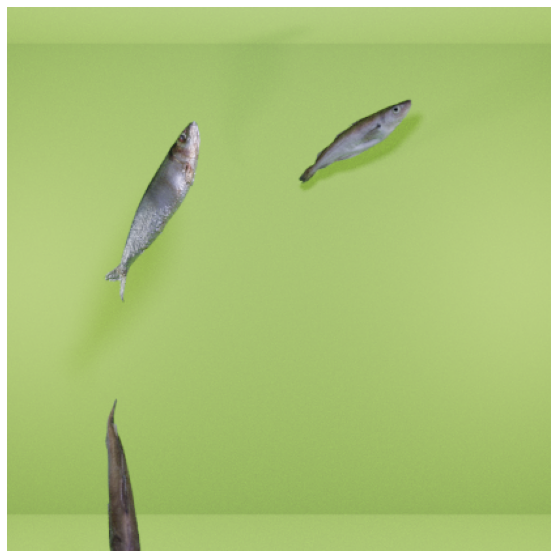

In [27]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img: Image.Image, classes: Iterable, boxes: Iterable):
    fig, ax = plt.subplots(figsize=(16,10))
    plt.imshow(img)
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h

        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                ax.text(xmin, ymin, CLASSES[cls], fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
            except:
                pass
            
    plt.axis('off')
    plt.show()

    
def postprocess(logits: torch.Tensor, boxes: torch.Tensor):
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.1
    if any(keepmask) == False:
        return torch.Tensor(), torch.Tensor()
#     return logits.argmax(-1), boxes
    return logits[keepmask].argmax(-1), boxes[keepmask]

    
def eval_model(model, image):
    with torch.no_grad():
        model.eval()
        
        output = model([image.to(device)])
        
        boxes = output['pred_boxes'][0]
        logits = output['pred_logits'][0]
        print(logits.argmax(-1))
        
        logits_, boxes_ = postprocess(logits, boxes)
        
        plot_results(image.numpy().transpose((1,2,0)), logits_, boxes_)
    
x, y = traingen[3]
eval_model(model, x)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [ ]:
raise ValueError

In [ ]:
import time

boii = tqdm(range(10), leave=False)

for i in boii:
    time.sleep(0.05)

boii.disable = False
boii.set_postfix({'BABA':'yeye'})
# boii.refresh()

In [ ]:
3000//2

In [ ]:
batch_size = 2
batchnr = 4999
n = 10000
print(n//batch_size)
np.arange(n)[batch_size*batchnr:batch_size*(batchnr+1)]

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_fn(dataloader, model, criterion, optimizer, device, scheduler):
    model.train()
    criterion.train()
    
    mean = np.array([0.64817397, 0.75178422, 0.43881263])
    std = np.array([0.06833826, 0.07720845, 0.05868721])
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(dataloader, total=len(dataloader)-1)
    
    for step, (images, targets) in enumerate(tk0):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(), BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss


def eval_fn(dataloader, model, criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        tk0 = tqdm(dataloader, total=len(dataloader)-1)
        for step, (images, targets) in enumerate(tk0):
            
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss